In [1]:
import os, glob, csv, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import r2_score, explained_variance_score

In [2]:
def make_pred_df():
    
    svm_files = glob.glob(r'../results/*svm*English*.tsv')
    
    svm_dfs = []
    for file in svm_files:
        df = pd.read_csv(file, sep='\t', names=['feature', 'pred', 'true'])
        df['model'] = len(df) * [file.lstrip('../results\preds').rstrip('.tsv')[:5]]
        df['fold'] = len(df) * [file[-5]]
        svm_dfs.append(df)
    svm_preds = pd.concat(svm_dfs, axis=0, ignore_index=True)
    
    return svm_preds

In [3]:
def evaluate(pred_df):
    
    exp_var = explained_variance_score(pred_df['true'], pred_df['pred'])
    r2 = r2_score(pred_df['true'], pred_df['pred'])
    
    return exp_var, r2

In [4]:
def make_eval_df(pred_df):

    models = []
    folds = []
    exp_var_scores = []
    r2_scores = []
    features = []

    for (model, feature, fold), group in pred_df.groupby(['model', 'feature', 'fold']):
        
        # evaluate
        exp_var, r2 = evaluate(group)

        # collect information
        folds.append(fold)
        models.append(model)
        features.append(feature)
        exp_var_scores.append(exp_var)
        r2_scores.append(r2)

    # make df
    eval_df = pd.DataFrame()
    eval_df['model'] = models
    eval_df['fold'] = folds
    eval_df['feature'] = features
    eval_df['exp_var'] = exp_var_scores
    eval_df['r2'] = r2_scores
    
    return eval_df

In [5]:
eval_df = make_eval_df(make_pred_df())
eval_df

,model,fold,feature,exp_var,r2
0,-all-,0,scaled_first_pass_dur,0.533155,0.478720
1,-all-,1,scaled_first_pass_dur,0.533597,0.480028
2,-all-,2,scaled_first_pass_dur,0.534951,0.456379
3,-all-,3,scaled_first_pass_dur,0.533066,0.483868
4,-all-,4,scaled_first_pass_dur,0.537158,0.482410
...,...,...,...,...,...
75,-ling,0,scaled_tot_regr_from_dur,-0.071062,-0.079541
76,-ling,1,scaled_tot_regr_from_dur,-0.077207,-0.089466
77,-ling,2,scaled_tot_regr_from_dur,-0.071945,-0.081172
78,-ling,3,scaled_tot_regr_from_dur,-0.085279,-0.098328


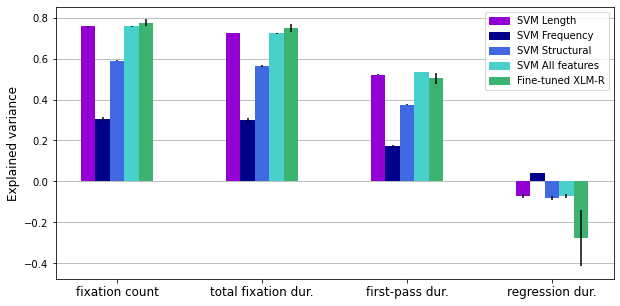

In [10]:
import matplotlib.patches as mpatches

eval_df = make_eval_df(make_pred_df())
eval_metric = 'ev'

colors = [ 'darkviolet', 'darkblue', 'royalblue', 'mediumturquoise', 'mediumseagreen']
models = ['-leng', '-freq', '-ling', '-all-', 'xlm']
features = list(set(eval_df['feature']))

n=-0.2
c=0
plt.figure(figsize=(10,5))

for model in models:

    if model != 'xlm':
        eval_df_target = eval_df.groupby('model').get_group(model).reset_index(drop=True)

        all_data = []

        for feature in features:

            df_feature = eval_df_target.groupby('feature').get_group(feature).reset_index(drop=True)
            scores = df_feature.describe()

            all_data.append([f'{feature}', 
                                   scores['r2']['mean'],
                                   scores['exp_var']['mean'],
                                   scores['r2']['std'],
                                   scores['exp_var']['std']
                            ])

    # order data by r2 score
    df_all_data = pd.DataFrame(all_data, columns=['feature', 'r2', 'ev', 'r2_std', 'ev_std'])

    df_all_data_sorted = df_all_data.sort_values(by=[eval_metric], ascending=False).reset_index(drop=True)
    
    x = np.arange(4)
    if model == 'xlm':
        if eval_metric == 'ev':
            y = [0.775441, 0.749961, 0.503705, -0.277782]
            yerr = [0.016084, 0.019704, 0.027312, 0.137205]
        elif eval_metric == 'r2':
            y = [-0.634844, -0.648711, -0.873324, -0.957000]
            yerr = [0.345496, 0.240352, 0.267119, 0.445156]
    else:
        y = df_all_data_sorted[eval_metric]
        yerr = df_all_data_sorted[f'{eval_metric}_std']
                                  
    width = 0.1
    plt.bar(x+n, y, width, zorder=3,color=colors[c],yerr=yerr)
    n+=0.1
    c+=1
    
    plt.xticks(ticks=[0,1,2,3],labels=['fixation count', 'total fixation dur.', 'first-pass dur.', 'regression dur.'], fontsize=12)
    plt.grid(axis='y', zorder=0)
    plt.ylabel(f'Explained variance', fontsize=12)
    e_patch = mpatches.Patch(color=colors[0], label='SVM Length')
    k_patch = mpatches.Patch(color=colors[1], label='SVM Frequency')
    t_patch = mpatches.Patch(color=colors[2], label='SVM Structural')
    l_patch = mpatches.Patch(color=colors[3], label='SVM All features')
    x_patch = mpatches.Patch(color=colors[4], label='Fine-tuned XLM-R')
    plt.legend(handles=[e_patch, k_patch, t_patch, l_patch, x_patch], loc='upper right')

    plt.savefig(f'feature-based-prediction_{eval_metric}.pdf', dpi=300, bbox_inches='tight')